In [1]:
#BLOCK 1
# 1. Install eksternal library jika diperlukan
!pip install xgboost catboost --quiet

# 2. Import libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV


warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# BLOCK 2
# 3. Load data dan preprocessing
file_path = '[LINK_DRIVE]'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

# Label encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['weather'])

# Fitur dan target
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = df['label']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# BLOCK 3
# 4. Fungsi pencarian hyperparameter otomatis
def get_best_model(name, run, X_train, y_train):
    if name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=run)
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    elif name == 'AdaBoost':
        base_model = AdaBoostClassifier(random_state=run)
        param_dist = {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.1, 0.5, 1.0]
        }
    elif name == 'XGBoost':
        base_model = XGBClassifier(eval_metric='mlogloss', random_state=run, use_label_encoder=False)
        param_dist = {
            'n_estimators': [100, 150],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.9, 1.0]
        }
    elif name == 'CatBoost':
        base_model = CatBoostClassifier(verbose=0, random_state=run)
        param_dist = {
            'iterations': [100, 200],
            'depth': [4, 6, 8],
            'learning_rate': [0.03, 0.05, 0.1]
        }
    else:
        return None

    search = RandomizedSearchCV(
        base_model,
        param_distributions=param_dist,
        n_iter=5,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=run
    )
    search.fit(X_train, y_train)
    return search.best_estimator_

# 5. Konfigurasi training berulang
n_runs = 10
all_results = defaultdict(list)

for run in range(n_runs):
    print(f"\n🌀 Pelatihan Ulang ke-{run + 1}")
    results = {}

    # Split data ulang
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=run, stratify=y
    )

    # Inisialisasi model terbaik untuk setiap algoritma
    model_names = ['Random Forest', 'AdaBoost', 'XGBoost', 'CatBoost']
    models = {name: get_best_model(name, run, X_train, y_train) for name in model_names}

    # Evaluasi semua model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.squeeze(y_pred)
        acc = accuracy_score(y_test, y_pred)

        used_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))

        report = classification_report(
            y_test, y_pred,
            labels=used_labels,
            target_names=le.inverse_transform(used_labels),
            output_dict=True,
            zero_division=0
        )

        results[name] = {
            'model': model,
            'accuracy': acc,
            'report': report
        }

        all_results[name].append(acc)

        print(f"\n===== {name} =====")
        print(f"Akurasi: {acc:.4f}")
        print(classification_report(
            y_test, y_pred,
            labels=used_labels,
            target_names=le.inverse_transform(used_labels),
            zero_division=0
        ))

    final_results = results



🌀 Pelatihan Ulang ke-1

===== Random Forest =====
Akurasi: 0.8464
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        11
         fog       1.00      0.05      0.10        20
        rain       0.97      0.91      0.94       129
        snow       0.33      0.20      0.25         5
         sun       0.77      1.00      0.87       128

    accuracy                           0.85       293
   macro avg       0.61      0.43      0.43       293
weighted avg       0.83      0.85      0.80       293


===== AdaBoost =====
Akurasi: 0.8464
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        11
         fog       0.00      0.00      0.00        20
        rain       0.96      0.93      0.94       129
        snow       0.00      0.00      0.00         5
         sun       0.76      1.00      0.86       128

    accuracy                           0.85       293
   macro avg       0.34   

In [ ]:
# BLOCK 4
# 6. Hasil rata-rata Akurasi
print(f"\n📈 Rata-rata Akurasi Setelah {n_runs} Kali Pelatihan:\n")
for name, accs in all_results.items():
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"{name:<15} → Mean: {mean_acc:.4f} | Std Dev: {std_acc:.4f}")


📈 Rata-rata Akurasi Setelah 10 Kali Pelatihan:

Random Forest   → Mean: 0.8461 | Std Dev: 0.0095
AdaBoost        → Mean: 0.8416 | Std Dev: 0.0091
XGBoost         → Mean: 0.8410 | Std Dev: 0.0085
CatBoost        → Mean: 0.8474 | Std Dev: 0.0086



📊 Confusion Matrix - Random Forest


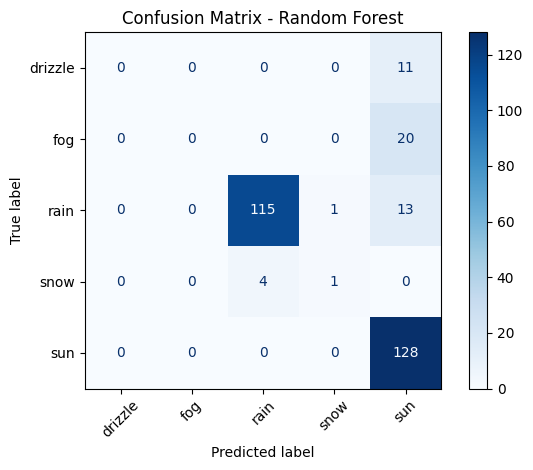


📊 Confusion Matrix - AdaBoost


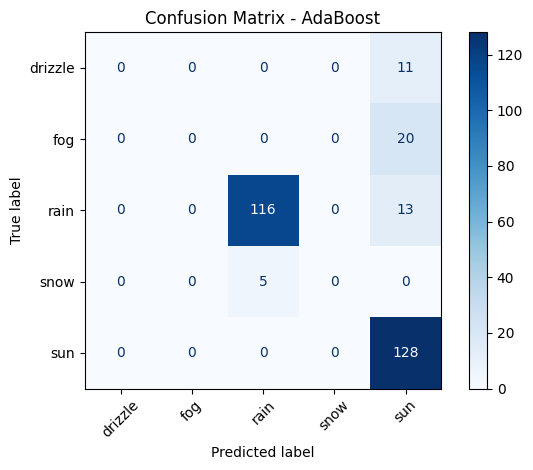


📊 Confusion Matrix - XGBoost


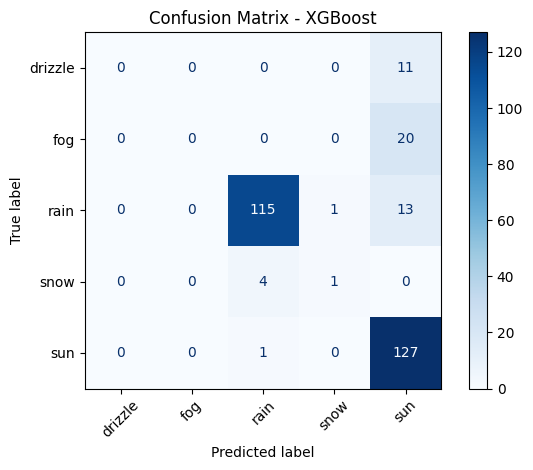


📊 Confusion Matrix - CatBoost


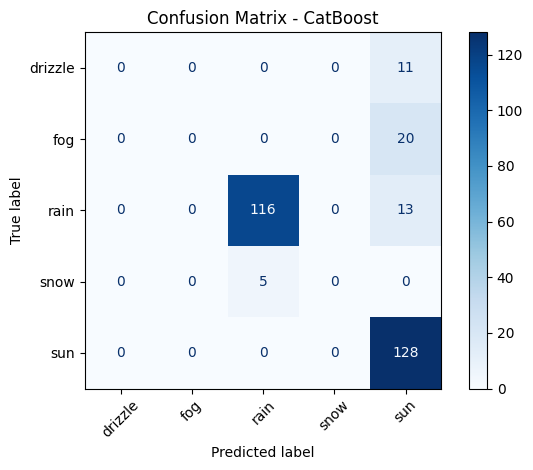

In [ ]:
# BLOCK 5
# 7. Confusion Matrix
for name, res in results.items():
    model = res['model']
    y_pred = np.squeeze(model.predict(X_test))

    # Hanya ambil label yang muncul di data
    used_labels = np.unique(np.concatenate([y_test, y_pred]))
    display_labels = le.inverse_transform(used_labels)

    print(f"\n📊 Confusion Matrix - {name}")
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=display_labels,
        cmap='Blues'
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




🔎 Feature Importance - Random Forest


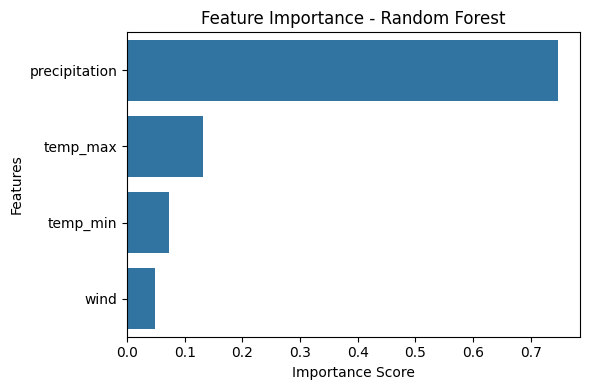


🔎 Feature Importance - AdaBoost


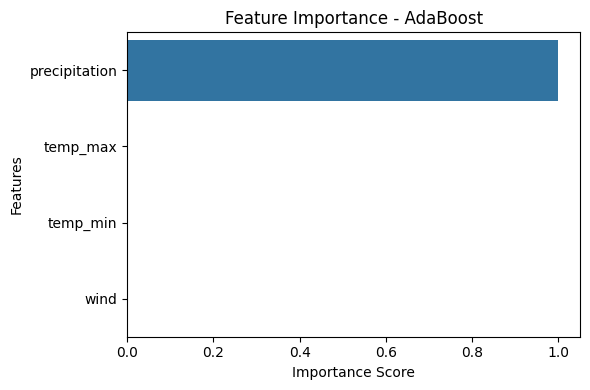


🔎 Feature Importance - XGBoost


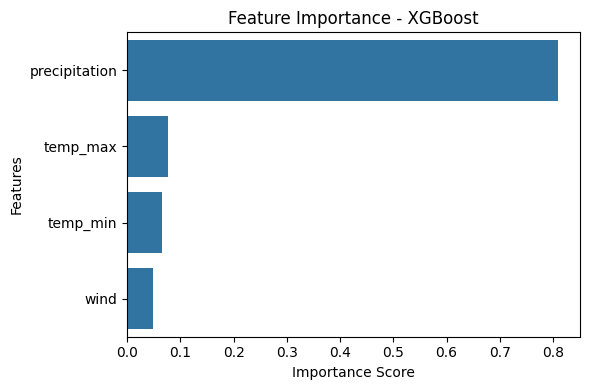


🔎 Feature Importance - CatBoost


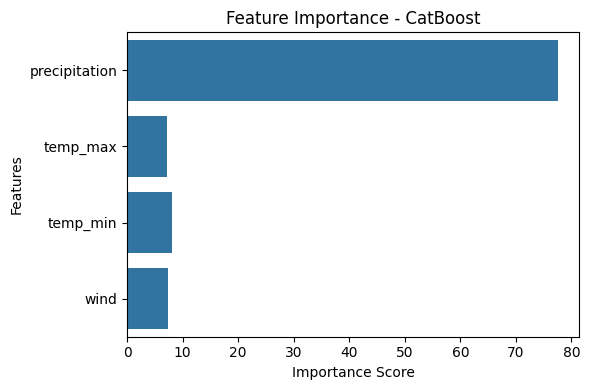

In [ ]:
# BLOCK 6
# 8.  FEATURE IMPORTANCE UNTUK SEMUA MODEL
def show_feature_importance(model, model_name, X):
    try:
        # Gunakan metode sesuai model
        if model_name == 'CatBoost':
            importances = model.get_feature_importance()
        else:
            importances = model.feature_importances_

        features = X.columns
        plt.figure(figsize=(6, 4))
        sns.barplot(x=importances, y=features)
        plt.title(f"Feature Importance - {model_name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()
    except AttributeError:
        print(f"{model_name} tidak mendukung feature_importances_.")

# Tampilkan feature importance dari setiap model
for name, res in results.items():
    print(f"\n🔎 Feature Importance - {name}")
    show_feature_importance(res['model'], name, X)


In [ ]:
# BLOCK 7
# 9. PREDIKSI CUACA BARU
# Format: [precipitation, temp_max, temp_min, wind]
new_data = pd.DataFrame([[5.2, 11.5, 4.2, 3.4]], columns=X.columns)

print("\n🌤️ Prediksi Cuaca Baru dari Semua Model:")
for name, res in results.items():
    model = res['model']
    pred = np.squeeze(model.predict(new_data))
    label = le.inverse_transform([int(pred)])[0]
    print(f"{name:<15}: {label}")



🌤️ Prediksi Cuaca Baru dari Semua Model:
Random Forest  : rain
AdaBoost       : rain
XGBoost        : rain
CatBoost       : rain
